# Understand the problems
Disclaimer, the content below is for brainstorming only. I have a PDF report, please read that.
## Context
Having csv file containing information about car listings. Defined tasks:
1. Build a model
- Work on brands make up 90% of the total cars -> Maybe filtering is a good option. 
- Predict the price of used cars -> Regression task
2. Define a success metrics 
- Maybe metrics related to regression tasks, including: R-squared and MAE
3. Build an API
- Objective is to develop a RESTful API for the model mentioned above -> Since this is a demo, maybe i will stick with FastAPI for a fast demo.
4. Data Analysis Questions
- How does mileage relate to car price? Is there a clear negative correlation? -> I think this question is more data-centric instead of model-centric, therefore using modeling techniques like SHAP value to interprete maybe is not suitable. Thus, sticking with statistic methods maybe more general. 
- Does the fuel type (petrol, diesel, etc.) have a noticeable impact on price? -> I can reframe this question as is fuel type is statistical significant with the price -> Maybe using statistics test -> Using some libraries. 
- How to compare two cars in the same segment? -> Still thinking (what is segment mean?)

## Scoring objective:
- How well does your model perform -> This maybe strongly related to the chosen metrics. 
- How effective is the selected metric in evaluating model performance -> Are these metrics align with what people are doing in real-life problem?
- How could your model be improved? -> Tbh, both modeling and data preparation are needed in order to improve the model's prediction. 

# Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib 
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys

In [2]:
# Load data
DATA_PATH = 'data'
MODEL_PATH = 'models'

In [3]:
ref = pd.read_csv(f'{DATA_PATH}/raw/car.csv') # for reference if needed
data = pd.read_csv(f'{DATA_PATH}/raw/car.csv')
unique_df = ref[~ref.duplicated()]
unique_df

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317611,150748445,110565749,1696580444000,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,150811050,110619804,1696753826000,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,150840647,110645035,1696835873000,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used
317618,148874300,108958993,1696836032000,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used


# EDA and Preprocessing

## Overview

In [4]:
# Check for the shape of the data
data.shape

(317636, 15)

Currently, the data has 317636 rows  with 15 columns

In [ ]:
# Check for the first 5 rows of the data
data.head()

,id,list_id,list_time,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,148468232,108616925,1693378633111,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,149864917,109805135,1694308247000,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,149580046,109560282,1693462201000,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,148601679,108727914,1693493126176,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,149530234,109517456,1693313503000,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used


This is what the first 5 records look like. It seems that id, list_id, list_time are quite vague -> need to ask stakeholders about the data dictionary.

In [6]:
# We care for some statistics of the data
data.describe()

,id,list_id,list_time,manufacture_date,seats,mileage_v2,price
count,3.176360e+05,3.176360e+05,3.176360e+05,317636.00000,283792.000000,317636.000000,3.175240e+05
mean,1.489581e+08,1.090510e+08,1.695835e+12,2016.53675,5.712529,61327.917528,6.265541e+08
std,3.484644e+06,2.878699e+06,1.131473e+09,26.07318,1.780515,92679.788593,7.284020e+08
min,4.588559e+07,2.989052e+07,1.691400e+12,-1.00000,-1.000000,0.000000,1.310720e+06
25%,1.490832e+08,1.091366e+08,1.695113e+12,2014.00000,5.000000,9000.000000,3.150000e+08
50%,1.499784e+08,1.099032e+08,1.695873e+12,2019.00000,5.000000,42000.000000,4.900000e+08
75%,1.504550e+08,1.103140e+08,1.696577e+12,2022.00000,7.000000,82000.000000,7.150000e+08
max,1.513698e+08,1.110970e+08,1.698210e+12,2023.00000,16.000000,999999.000000,3.750000e+10


We can see that manufacture_date and seats has negative values in it, which impose errors. We should drop those records as well.

In [7]:
data.describe(include='object')

,brand,model,origin,type,gearbox,fuel,color,condition
count,317586,317586,234317,272934,316243,317542,221540,317636
unique,67,521,10,9,4,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,65455,15719,116368,90709,239222,259244,72035,270089


We can see that there are 67 brands and 521 models in total, however there may be some duplicate as well. Which make statistics unreliable.

In [8]:
# Drop the id, list_id, list_time columns
data = data.drop(['id', 'list_id', 'list_time'], axis=1)

In [9]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317631,2007,Hyundai,Veracruz,Hàn Quốc,SUV / Cross over,7.0,AT,oil,NaN,110000,535000000.0,used
317632,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317633,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317634,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used


Ok, so after we drop useless columns, we can further investigate the records. As observe within the dataframe, there are some NaN values, which may impose error. Further investigation must resolve this problem.

## Convert data types

In [ ]:
# Check for the data types of the columns
data.dtypes

manufacture_date      int64
brand                object
model                object
origin               object
type                 object
seats               float64
gearbox              object
fuel                 object
color                object
mileage_v2            int64
price               float64
condition            object
dtype: object

In [11]:
# Convert data types of the columns
data['brand'] = data['brand'].astype('category')
data['model'] = data['model'].astype('category')
data['origin'] = data['origin'].astype('category')    
data['gearbox'] = data['gearbox'].astype('category')
data['fuel'] = data['fuel'].astype('category')
data['type'] = data['type'].astype('category')
data['color'] = data['color'].astype('category')
data['condition'] = data['condition'].astype('category')
data.dtypes

manufacture_date       int64
brand               category
model               category
origin              category
type                category
seats                float64
gearbox             category
fuel                category
color               category
mileage_v2             int64
price                float64
condition           category
dtype: object

We have to convert the data back to the correct data type. Although in some scenario, object and category can be used interchangeably, I still prefer category over object, especially for these variable.

## Handling duplicate

In [12]:
# Display several duplicates
duplicates = data[data.duplicated(keep=False) | data.duplicated(keep='first')]
duplicates.sort_values(by=list(duplicates.columns))

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
44959,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58892,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
58893,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
79332,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,8.900000e+08,used
...,...,...,...,...,...,...,...,...,...,...,...,...
19763,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41234,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
41235,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used
56436,2023,Volvo,S90,Đức,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used


We can say that the data is duplicate a lot. Therefore I will decide to drop those duplicated columns. Additionally, some error data also occurs in the dataset as well. We will need to remove them too.

In [13]:
data = data.drop_duplicates()
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 42083 rows and 12 columns


In [14]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
2,2016,Kia,Rio,Hàn Quốc,NaN,NaN,AT,petrol,NaN,78545,295000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
4,2001,Fiat,Siena,NaN,NaN,NaN,MT,petrol,white,200000,73000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


The size of the data has been dramatically decrease. However, the sale price of the car can also be effected by the perspective of the seller. Therefore, some scenarios where different salers have different prices for the same car. We will comeback to this step later, after we dealing with missing values, and after that, we can define those records again.

## Handling missing values

In [15]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,4,0.009505,category
model,4,0.009505,category
origin,12174,28.928546,category
type,5932,14.095953,category
seats,4724,11.225435,float64
gearbox,190,0.451489,category
fuel,6,0.014258,category
color,13036,30.976879,category
mileage_v2,0,0.000000,int64


If we put ourselves under the view of the buyer, we will definately not buy the car if we do not know what brand it was or what model it was. Therefore these fields may be very important to determine the sale price of the car. With that being said, I will drop records where brand, model and price is empty. 

In [16]:
# Records with missing values in the 'price','brand','model' column
# Select and print records with missing values in 'brand', 'model', and 'price'
missing_records = data[data[['brand', 'model', 'price']].isnull().any(axis=1)]
print("Records with missing values in 'brand', 'model', and 'target':")
missing_records

Records with missing values in 'brand', 'model', and 'target':


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1059,2023,Hyundai,Grand i10,Việt Nam,NaN,5.0,AT,petrol,NaN,0,NaN,new
1727,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,90000,190000000.0,used
5517,2005,Ford,Transit,NaN,Van,16.0,MT,oil,NaN,280000,NaN,used
12848,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,NaN,0,NaN,new
20958,2022,Suzuki,Ertiga,Nước khác,NaN,7.0,AT,hybrid,NaN,0,NaN,new
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
44958,-1,NaN,NaN,NaN,NaN,NaN,unknown,NaN,NaN,70000,890000000.0,used
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new


Maybe I will keep records with missing price for later inferencing (if these records are missing the price only). The remains can be dropped.

In [17]:
# Keep records with missing 'price' only
missing_price_only = data[data['price'].isnull() & data.drop(columns=['price']).notnull().all(axis=1)]
print("Records with missing 'price' only:")
missing_price_only

Records with missing 'price' only:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
22164,2023,Hyundai,Accent,Việt Nam,Sedan,5.0,AT,petrol,white,0,NaN,new
23120,2023,Hyundai,Accent,Hàn Quốc,Sedan,5.0,AT,petrol,white,0,NaN,new
159136,2011,Toyota,Fortuner,Việt Nam,SUV / Cross over,7.0,AT,petrol,silver,110000,NaN,used
165378,2022,Hyundai,Stargazer,Hàn Quốc,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
169034,2023,Hyundai,Custin,Việt Nam,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181000,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,white,0,NaN,new
181926,2022,Hyundai,Stargazer,Nước khác,Minivan (MPV),7.0,AT,petrol,black,0,NaN,new


In [18]:
missing_price_only.to_csv((f'{DATA_PATH}/raw/inference.csv'), index=False)
data = data[~data.index.isin(missing_records.index)]


In [19]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,12166,28.923969,category
type,5924,14.083971,category
seats,4719,11.219153,float64
gearbox,190,0.451714,category
fuel,2,0.004755,category
color,13023,30.961438,category
mileage_v2,0,0.000000,int64


Ok, now we need to further investigate to see what we can do to the remaining missing values. 

In [20]:
# Overall statistics of the data
data.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,42062.000000,42062,42062,29896,36138,37343.000000,41872,42060,29039,42062.000000,4.206200e+04,42062
unique,NaN,67,521,10,9,NaN,4,4,12,NaN,NaN,2
top,NaN,Toyota,Innova,Việt Nam,Sedan,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,8957,2067,14697,12489,NaN,30162,34847,9358,NaN,NaN,38343
mean,2016.082640,NaN,NaN,NaN,NaN,5.661945,NaN,NaN,NaN,70524.350601,5.677237e+08,NaN
std,6.370362,NaN,NaN,NaN,NaN,1.737503,NaN,NaN,NaN,103365.243520,7.137355e+08,NaN
min,1980.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,0.000000,1.310720e+06,NaN
25%,2013.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,14000.000000,2.750000e+08,NaN
50%,2018.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,50000.000000,4.500000e+08,NaN
75%,2021.000000,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,90000.000000,6.500000e+08,NaN


In [21]:
3.75e10

37500000000.0

There is a car around 37Bil VND (kinda suspicious). There is also a car that ran 999999 km (kinda suspicious for me) .Seats also have a values where it is equal to -1, which is obviously wrong :). Detect and drop those as well. 

In [ ]:
# Drop rows where seats is less than or equal to 0
data = data[data['seats'] > 0]

data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317613,2015,Kia,K3,NaN,Sedan,5.0,AT,petrol,white,1234,370000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [23]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,37222.000000,37222.000000,37222.000000,3.722200e+04
mean,2016.252593,5.683601,69975.821718,5.624639e+08
std,6.178039,1.698230,101096.358858,6.318453e+08
min,1980.000000,2.000000,0.000000,1.310720e+06
25%,2013.000000,5.000000,14278.250000,2.820000e+08
50%,2018.000000,5.000000,50000.000000,4.550000e+08
75%,2021.000000,7.000000,90000.000000,6.500000e+08
max,2023.000000,16.000000,999999.000000,3.750000e+10


In [24]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,37222,37222,28757,35511,37032,37222,28181,37222
unique,66,481,10,9,3,4,12,2
top,Toyota,Innova,Việt Nam,Sedan,AT,petrol,white,used
freq,8078,1914,14246,12332,26820,30766,9044,33557


In [25]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,8465,22.741927,category
type,1711,4.596744,category
seats,0,0.000000,float64
gearbox,190,0.510451,category
fuel,0,0.000000,category
color,9041,24.289399,category
mileage_v2,0,0.000000,int64


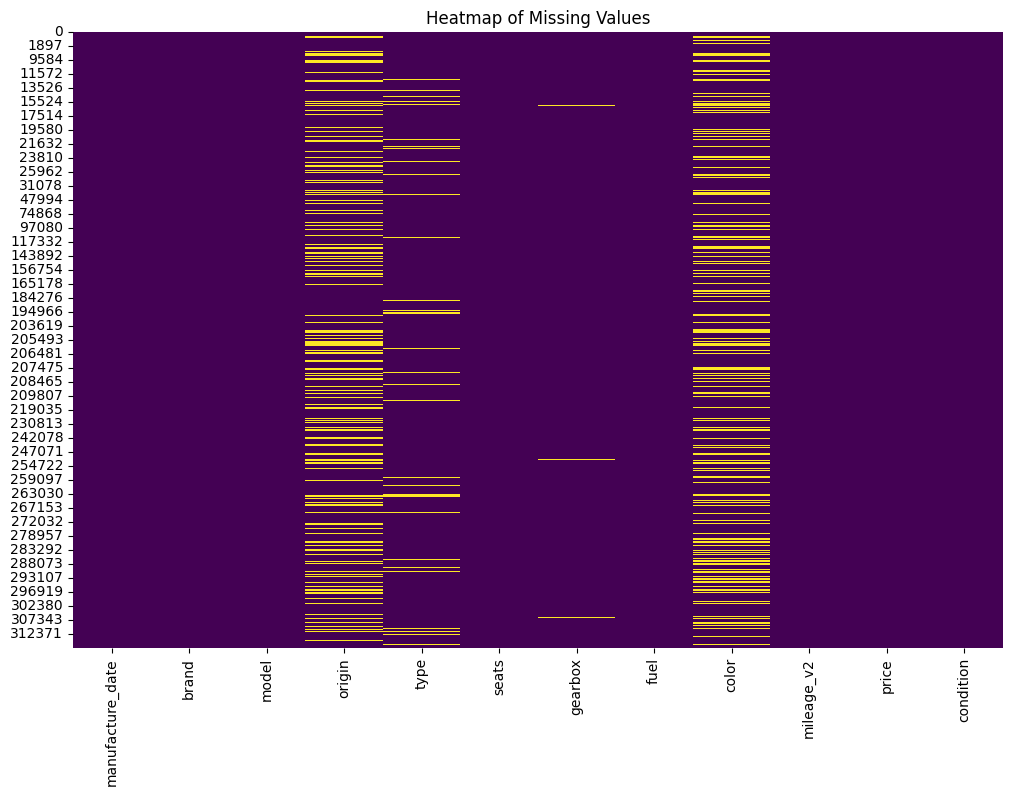

In [26]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

We can see that there is some missing regions, my best guests is that something must went wrong in the data gathering process, which lead to this bizard situations. I suspect that some brand and models are so unique such that it only have one type/origin or so on. I will need to investigate on that as well. 

In [27]:
# Group by 'brand' and 'model' and count occurrences
brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')
# Sort the values in descending order
brand_model_counts = brand_model_counts.sort_values(by='count', ascending=False)

/tmp/ipykernel_1851/3156361840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  brand_model_counts = data.groupby(['brand', 'model']).size().reset_index(name='count')


In [28]:
# Identify unique or rare combinations
unique_combinations = brand_model_counts[(brand_model_counts['count'] >= 1) & (brand_model_counts['count'] <= 5)]
# Filter the original DataFrame to get records with unique combinations
unique_records = data[data.set_index(['brand', 'model']).index.isin(unique_combinations.set_index(['brand', 'model']).index)]
print("Records with unique or rare brand and model combinations:")
unique_records

Records with unique or rare brand and model combinations:


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
76,2023,Hyundai,County,Việt Nam,Minivan (MPV),7.0,AT,petrol,black,0,848000000.0,new
1264,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,200000000.0,used
1301,2005,Suzuki,Alto,NaN,NaN,2.0,MT,petrol,NaN,6789,58000000.0,used
1341,2003,Hyundai,Libero,Hàn Quốc,Pick-up (bán tải),4.0,MT,oil,white,262000,125000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
315307,1995,Jeep,CJ,Trung Quốc,NaN,5.0,MT,petrol,others,145874,80000000.0,used
316805,2013,SYM,T880,Hàn Quốc,Van,5.0,MT,petrol,gold,8888,68000000.0,used
317147,1980,Jeep,CJ,Mỹ,Mui trần,4.0,MT,petrol,red,10000,132000000.0,used
317166,1997,Lada,Dòng khác,Nhật Bản,Sedan,5.0,MT,hybrid,blue,1235,10000000.0,used


In [29]:
unique_records.describe(include='all')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
count,530.000000,530,530,485,456,530.000000,530,530,453,530.000000,5.300000e+02,530
unique,NaN,61,219,10,9,NaN,3,4,12,NaN,NaN,2
top,NaN,Hyundai,Dòng khác,Nhật Bản,SUV / Cross over,NaN,AT,petrol,white,NaN,NaN,used
freq,NaN,43,75,80,143,NaN,335,440,103,NaN,NaN,508
mean,2008.352830,NaN,NaN,NaN,NaN,5.079245,NaN,NaN,NaN,95350.813208,9.983483e+08,NaN
std,10.312235,NaN,NaN,NaN,NaN,1.560786,NaN,NaN,NaN,151134.620010,2.303395e+09,NaN
min,1980.000000,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,5.000000e+06,NaN
25%,2004.000000,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,14250.000000,1.050000e+08,NaN
50%,2009.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,60000.000000,2.900000e+08,NaN
75%,2016.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,104750.000000,6.500000e+08,NaN


In [30]:
# Check if there is any missing values in these records
unique_records_missing = unique_records.isnull().sum()
unique_records_missing 

manufacture_date     0
brand                0
model                0
origin              45
type                74
seats                0
gearbox              0
fuel                 0
color               77
mileage_v2           0
price                0
condition            0
dtype: int64

I don't see how this can be integrate with the current workflow. However, people should not selling cars which the origin of the cars is unknown, and because the origin is unknown, we can not sell the car legally (Based on this link: https://www.baogiaothong.vn/he-luy-khi-mua-xe-khong-giay-to-192240319074428423.htm). With that being said, car with unknown origin should be dropped since it may cause unpredictable effect when aligning between business logic and model logic.

In [ ]:
data = data.dropna(subset=['origin'])
print(f'The data now has: {data.shape[0]} rows and {data.shape[1]} columns')

The data now has: 28757 rows and 12 columns


In [32]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used


In [33]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1379,4.795354,category
seats,0,0.000000,float64
gearbox,119,0.413812,category
fuel,0,0.000000,category
color,3927,13.655806,category
mileage_v2,0,0.000000,int64


In [34]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,28757.000000,28757.000000,28757.000000,2.875700e+04
mean,2016.337518,5.672567,67985.473415,5.766872e+08
std,6.433763,1.703250,101642.499146,6.568278e+08
min,1980.000000,2.000000,0.000000,1.310720e+06
25%,2013.000000,5.000000,11000.000000,2.800000e+08
50%,2018.000000,5.000000,48000.000000,4.600000e+08
75%,2021.000000,7.000000,90000.000000,6.700000e+08
max,2023.000000,16.000000,999999.000000,3.750000e+10


In [35]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,28757,28757,28757,27378,28638,28757,24830,28757
unique,66,472,10,9,3,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,6074,1434,14246,9367,20911,23532,7896,25108


Now the remaining problems is how to deal with origin, type and color. When we reach this step, I think that visualization will be a very powerful tool. So let dive in !

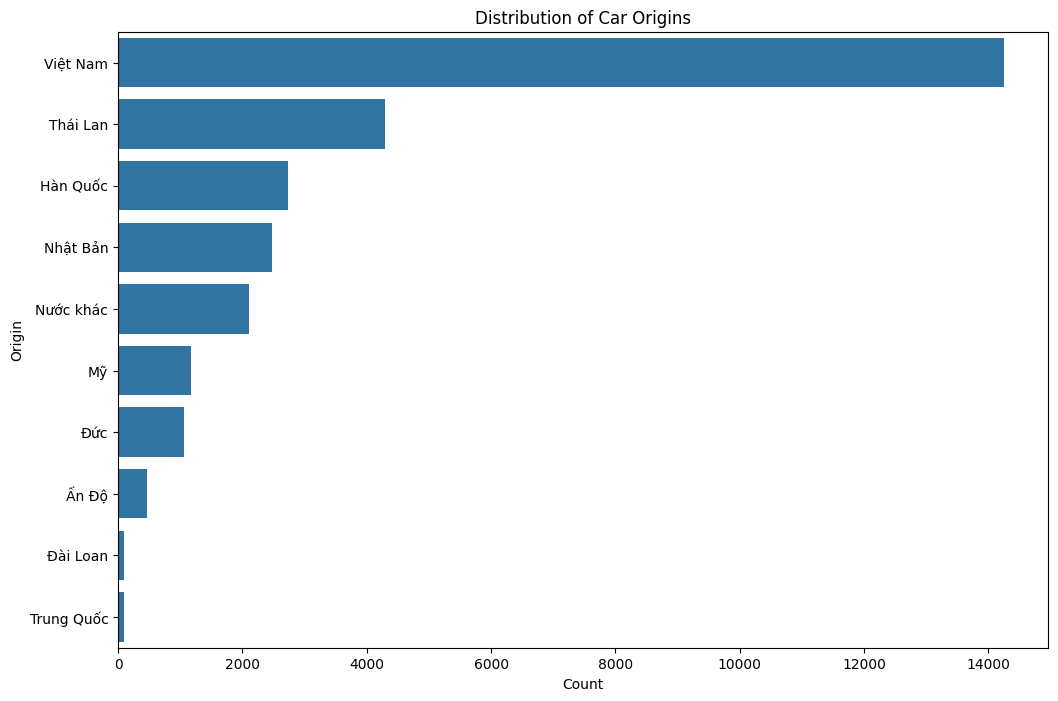

In [36]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='origin', order=data['origin'].value_counts().index)
plt.title('Distribution of Car Origins')
plt.xlabel('Count')
plt.ylabel('Origin')
plt.show()

Viet Nam took the largest proportion in manufacturing cars. 

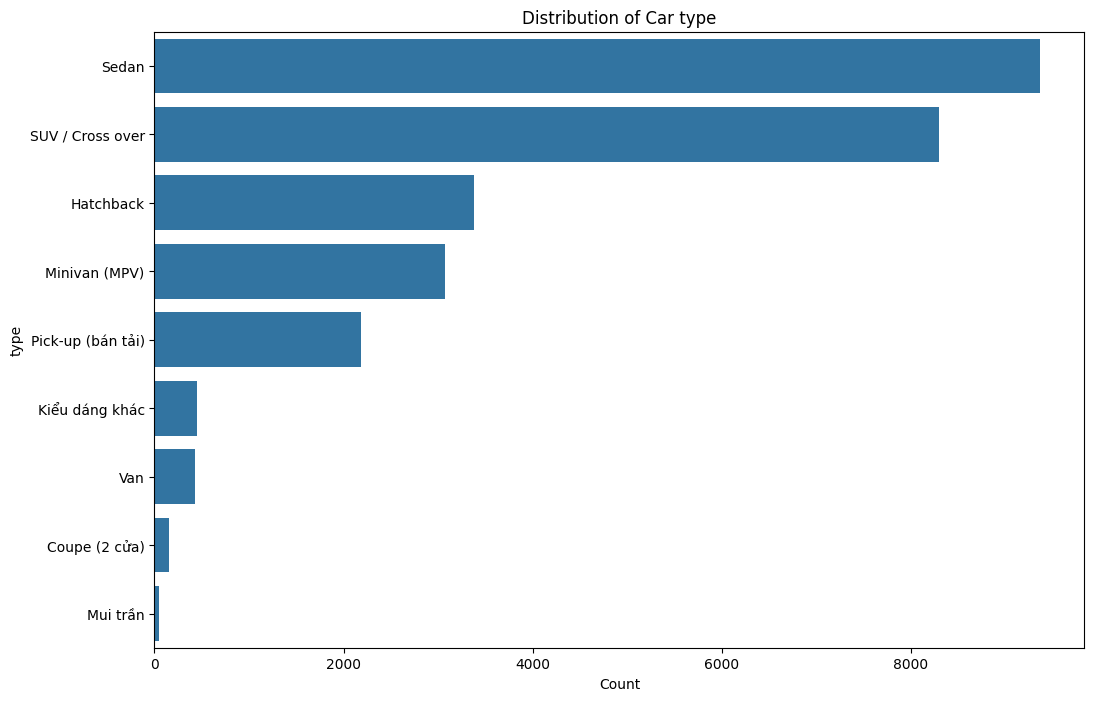

In [37]:
# Print the plot of car type
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='type', order=data['type'].value_counts().index)
plt.title('Distribution of Car type')
plt.xlabel('Count')
plt.ylabel('type')
plt.show()

Sedan and SUV are most populars. Mui Tran isn't that popular, maybe it is expensive and people struggle to afford it.

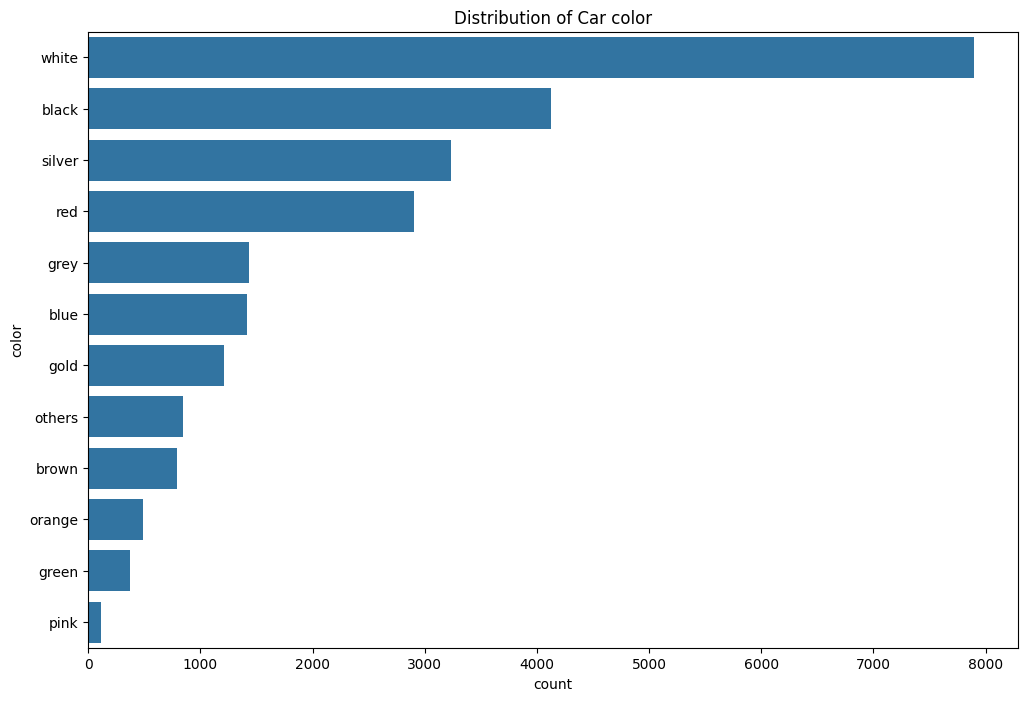

In [38]:
# Print the plot of origin
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='color', order=data['color'].value_counts().index)
plt.title('Distribution of Car color')
plt.ylabel('color')
plt.show()

In [ ]:
data['gearbox'].describe()

count     28638
unique        3
top          AT
freq      20911
Name: gearbox, dtype: object

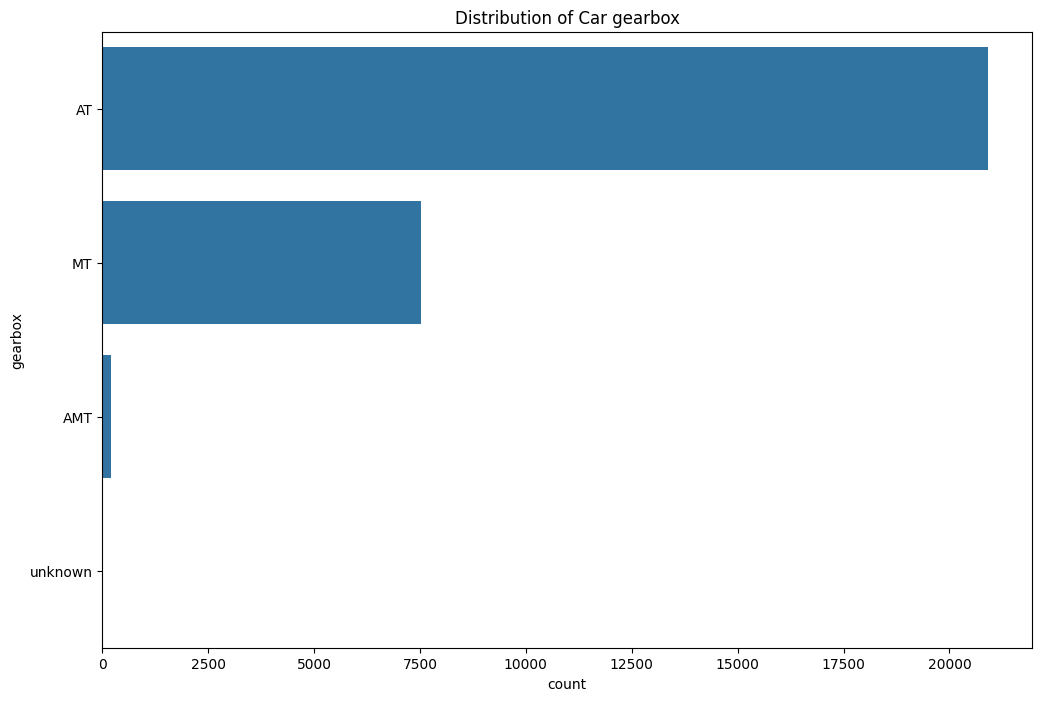

In [40]:
# Print the plot of gearboxes
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='gearbox', order=data['gearbox'].value_counts().index)
plt.title('Distribution of Car gearbox')
plt.ylabel('gearbox')
plt.show()

In [ ]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1379,4.795354,category
seats,0,0.000000,float64
gearbox,119,0.413812,category
fuel,0,0.000000,category
color,3927,13.655806,category
mileage_v2,0,0.000000,int64


We will come back to this step after handling potential outliers.

There is nothing much i can do now without having a deep knowledge for cars. Therefore the safe option is to change the NaN values to unknown.

### Comback to handle duplicate values

In [42]:
exp_data = data.copy()

In [43]:
# Define feature cols
feature_cols = ['manufacture_date',
 'brand',
 'model',
 'origin',
 'type',
 'seats',
 'gearbox',
 'fuel',
 'color',
 'mileage_v2',
 'condition']
# Create a new column by concatenating other columns
exp_data['concatenated'] = exp_data[feature_cols].astype(str).agg('_'.join, axis=1)

# Check for duplicates in the concatenated column but with different prices
duplicates_with_diff_price = exp_data[exp_data.duplicated(subset=['concatenated'], keep=False) & exp_data.duplicated(subset=['concatenated', 'price'], keep=False) == False]

duplicates_with_diff_price[['concatenated', 'price']].sort_values(by='concatenated').tail()

,concatenated,price
104120,2023_Volkswagen_Virtus_Ấn Độ_Sedan_5.0_AT_petr...,6.990000e+08
21706,2023_Volvo_S90_Nước khác_Sedan_5.0_AT_petrol_b...,2.140000e+09
18684,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...,2.145000e+09
88520,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...,2.099000e+09
19762,2023_Volvo_S90_Đức_Sedan_5.0_AT_petrol_black_3...,2.099000e+09


In [44]:
# Identify duplicates based on the concatenated values
exp_duplicated = duplicates_with_diff_price[duplicates_with_diff_price.duplicated('concatenated', keep=False)]

# Display the duplicate records
exp_duplicated.sort_values(by='concatenated')

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
8144,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,1.900000e+08,used,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...
1264,1980,Jeep,Dòng khác,Mỹ,NaN,4.0,AT,petrol,NaN,20000,2.000000e+08,used,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...
309187,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,4.300000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
308996,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,4.700000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
308186,1980,Jeep,Wrangler,Mỹ,Mui trần,5.0,MT,oil,green,187642,5.700000e+07,used,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,2023,Volkswagen,Touareg,Đức,SUV / Cross over,5.0,AT,petrol,others,0,3.348000e+09,new,2023_Volkswagen_Touareg_Đức_SUV / Cross over_5...
38032,2023,Volkswagen,Touareg,Đức,Sedan,5.0,AT,petrol,white,0,2.899000e+09,new,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...
83564,2023,Volkswagen,Touareg,Đức,Sedan,5.0,AT,petrol,white,0,2.699000e+09,new,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...
88520,2023,Volvo,S90,Việt Nam,Sedan,5.0,AT,petrol,black,3000,2.099000e+09,used,2023_Volvo_S90_Việt Nam_Sedan_5.0_AT_petrol_bl...


Based on what we have observed, it is safe to say that different people truly sale their car differently eventhough the configuration was the same. Therefore in order to minimize the error, I suggest we group them and take the average of the price. I think this approach is suitable because owners have a more clear view about what car price that they should sell on the market compared to other salers


In [45]:
exp_merge_price = exp_duplicated.groupby('concatenated').agg({'price': 'mean'}).reset_index()

In [46]:
exp_merge_price

,concatenated,price
0,1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_2...,1.950000e+08
1,1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_gree...,4.900000e+07
2,1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_pe...,2.666667e+07
3,1980_Toyota_Dòng khác_Nhật Bản_Sedan_5.0_MT_pe...,1.045000e+08
4,1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol...,3.550000e+07
...,...,...
4081,2023_Volkswagen_Touareg_Nước khác_SUV / Cross ...,2.799000e+09
4082,2023_Volkswagen_Touareg_Nước khác_nan_5.0_AT_p...,2.849000e+09
4083,2023_Volkswagen_Touareg_Đức_SUV / Cross over_5...,3.048667e+09
4084,2023_Volkswagen_Touareg_Đức_Sedan_5.0_AT_petro...,2.799000e+09


Okay, so far so good, now we have carefully handle records where the same configurations appear frequently. Now we need to merge it with the data, then remove duplicated as before.

In [47]:
data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)
data

/tmp/ipykernel_1851/242004034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['concatenated'] = data[feature_cols].astype(str).agg('_'.join, axis=1)


,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,315000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [48]:
# Create a dictionary from exp_merge_price for efficient lookup
price_dict = dict(zip(exp_merge_price['concatenated'], exp_merge_price['price']))
price_dict

{'1980_Jeep_Dòng khác_Mỹ_nan_4.0_AT_petrol_nan_20000_used': 195000000.0,
 '1980_Jeep_Wrangler_Mỹ_Mui trần_5.0_MT_oil_green_187642_used': 49000000.0,
 '1980_Mercedes Benz_E Class_Đức_Sedan_5.0_MT_petrol_blue_200000_used': 26666666.666666668,
 '1980_Toyota_Dòng khác_Nhật Bản_Sedan_5.0_MT_petrol_white_123_used': 104500000.0,
 '1983_Toyota_Camry_Nhật Bản_Sedan_4.0_MT_petrol_blue_123123_used': 35500000.0,
 '1984_Mercedes Benz_Dòng khác_Nước khác_Sedan_5.0_MT_petrol_black_200000_used': 16999999.5,
 '1984_Toyota_Corolla_Nhật Bản_Sedan_5.0_MT_petrol_blue_59000_used': 19500000.0,
 '1985_Nissan_Sentra_Nhật Bản_Sedan_5.0_MT_petrol_green_99999_used': 27500000.0,
 '1985_Toyota_Corona_Nhật Bản_Sedan_4.0_MT_petrol_pink_200000_used': 26200000.0,
 '1985_Toyota_Dòng khác_Nhật Bản_Van_9.0_AT_petrol_silver_29_used': 39750000.0,
 '1986_Chrysler_LeBaron_Mỹ_Sedan_5.0_MT_petrol_black_178978_used': 21500000.0,
 '1987_Honda_Accord_Nhật Bản_Sedan_5.0_MT_petrol_grey_100000_used': 48666666.666666664,
 '1987_Nissan

In [49]:
another_data = data.copy()
another_data['price'] = another_data['concatenated'].map(price_dict).fillna(another_data['price'])
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...
317617,2018,Hyundai,Grand i10,Việt Nam,Hatchback,5.0,AT,petrol,red,87000,310000000.0,used,2018_Hyundai_Grand i10_Việt Nam_Hatchback_5.0_...


In [50]:
another_data = another_data.drop_duplicates()
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition,concatenated
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used,1980_Jeep_A2_Mỹ_SUV / Cross over_4.0_MT_petrol...
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used,2021_Honda_City_Nhật Bản_Sedan_5.0_AT_petrol_w...
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used,2020_Toyota_Vios_Việt Nam_Sedan_5.0_MT_petrol_...
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used,2022_Hyundai_Elantra_Việt Nam_Sedan_5.0_AT_pet...
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used,2018_Toyota_Innova_Việt Nam_SUV / Cross over_8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317587,2014,SYM,Dòng khác,Đài Loan,Coupe (2 cửa),4.0,MT,oil,NaN,900000,15000000.0,used,2014_SYM_Dòng khác_Đài Loan_Coupe (2 cửa)_4.0_...
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used,2019_Hyundai_Accent_Việt Nam_Sedan_5.0_MT_petr...
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used,2017_Kia_Sedona_Việt Nam_Minivan (MPV)_7.0_AT_...
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used,2004_Ssangyong_Musso_Hàn Quốc_SUV / Cross over...


In [51]:
another_data = another_data.drop('concatenated', axis=1)

In [52]:
another_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317587,2014,SYM,Dòng khác,Đài Loan,Coupe (2 cửa),4.0,MT,oil,NaN,900000,15000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used


In [53]:
another_data.to_csv("data/processed/handled_duplicate_data.csv", index=False)

Ok so there is no more problem with duplicate data. We can move on and deal with missing values

In [54]:
data = another_data.copy()

In [55]:
data.describe(include='number')

,manufacture_date,seats,mileage_v2,price
count,22811.000000,22811.000000,22811.000000,2.281100e+04
mean,2016.003858,5.656525,71961.158038,5.762355e+08
std,6.440561,1.688783,105583.510921,6.949204e+08
min,1980.000000,2.000000,0.000000,5.000000e+06
25%,2013.000000,5.000000,15000.000000,2.780000e+08
50%,2018.000000,5.000000,50000.000000,4.550000e+08
75%,2021.000000,7.000000,90000.000000,6.567143e+08
max,2023.000000,16.000000,999999.000000,3.750000e+10


In [56]:
data.describe(include='category')

,brand,model,origin,type,gearbox,fuel,color,condition
count,22811,22811,22811,21746,22704,22811,19817,22811
unique,66,472,10,9,3,4,12,2
top,Toyota,Ranger,Việt Nam,Sedan,AT,petrol,white,used
freq,4841,1081,11162,7484,16335,18734,6080,20882


In [57]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.000000,int64
brand,0,0.000000,category
model,0,0.000000,category
origin,0,0.000000,category
type,1065,4.668800,category
seats,0,0.000000,float64
gearbox,107,0.469072,category
fuel,0,0.000000,category
color,2994,13.125247,category
mileage_v2,0,0.000000,int64


Before decide what to do next, I want to make sure if these columns are related to the price, maybe i will try with anova

In [58]:
import stat
import scipy.stats as stats
# List of categorical columns
categorical_columns = ['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']

# copy the og dataframe

stat_data = data.copy()
stat_data = stat_data.dropna()
# Target variable
target = 'price'

# Perform ANOVA for each categorical column
anova_results = {}
for col in categorical_columns:
    groups = [stat_data[target][stat_data[col] == level].dropna() for level in stat_data[col].unique()]
    anova_results[col] = stats.f_oneway(*groups)

# Display the ANOVA results
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-statistic', 'p-value'])
print(anova_df)

           F-statistic        p-value
brand       146.058369   0.000000e+00
model        39.115684   0.000000e+00
origin      162.943360  1.019568e-298
type        160.689239  2.420592e-263
gearbox     667.190270  7.676879e-281
fuel         22.990435   7.527205e-15
color        50.033097  2.434119e-109
condition   406.963973   1.427912e-89


Ok, so basically, when dropping NaN, the model still have the predictive capability. Let see what if we change those nan to unknown and see what happen.

In [59]:
# List of categorical columns
categorical_columns = data.select_dtypes(include=['category', 'object']).columns

# Copy the original dataframe
stat_data = data.copy()

# Convert NaN or Null values to 'Unknown' in categorical columns
for col in categorical_columns:
    stat_data[col] = stat_data[col].astype('category').cat.add_categories('Unknown').fillna('Unknown')

# Target variable
target = 'price'

# Perform ANOVA for each categorical column
anova_results = {}
for col in categorical_columns:
    groups = [stat_data[target][stat_data[col] == level].dropna() for level in stat_data[col].unique()]
    anova_results[col] = stats.f_oneway(*groups)

# Display the ANOVA results
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['F-statistic', 'p-value'])
print(anova_df)

           F-statistic        p-value
brand       170.990679   0.000000e+00
model        44.914580   0.000000e+00
origin      191.303701   0.000000e+00
type        167.459546  1.002148e-308
gearbox     568.304044   0.000000e+00
fuel         31.298706   3.503583e-20
color        53.275531  3.011345e-127
condition   560.775976  1.713604e-122


Both dropping or changing to unknown both save the day, however, I will stick with dropping, especially when the missing percentage is not large. A p-value being absolute 0 mean that the observed samples are impossible under the null hypothesis (H0: these features has no significant value when calculate the price)

In [60]:
data = data.dropna()

In [ ]:
# calculate the missing values of each column
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
data_types = data.dtypes
# combine the missing values and percentage into a dataframe
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage, 'data_types': data_types})
missing_data

,Missing Values,Percentage,data_types
manufacture_date,0,0.0,int64
brand,0,0.0,category
model,0,0.0,category
origin,0,0.0,category
type,0,0.0,category
seats,0,0.0,float64
gearbox,0,0.0,category
fuel,0,0.0,category
color,0,0.0,category
mileage_v2,0,0.0,int64


Ok so now we have handling all the missing values, the model can now learn, hope it learn better :)

In [ ]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used


## Handling outliers

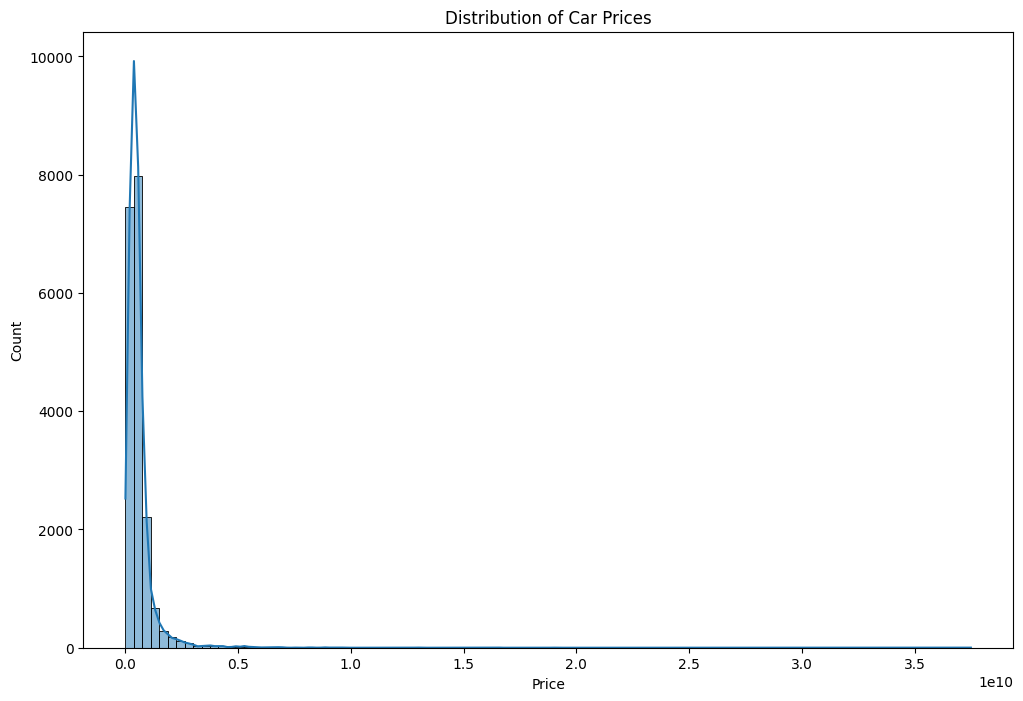

In [63]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='price', bins=100, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that while most of the car is low price, some cars remain to be higher price, which raise awareness on how these model/brand/type have a very high price, therefore what we are going to do is check for those instances, however, we need to identify them first. 

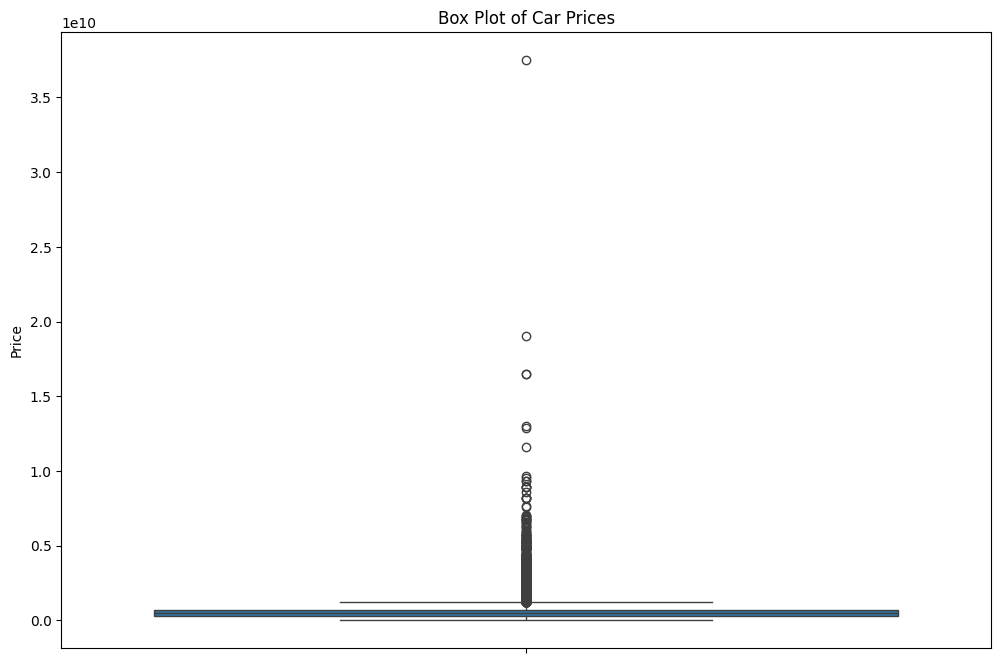

In [64]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, y='price')
plt.title('Box Plot of Car Prices')
plt.ylabel('Price')
plt.show()

In [65]:
# There is lots of outliers in the price column, we can investigate them further, using the IQR method. 
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
outliers

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
56,2023,Hyundai,Dòng khác,Hàn Quốc,SUV / Cross over,7.0,AT,oil,black,0,1.462278e+09,new
604,2023,Ford,Everest,Thái Lan,SUV / Cross over,7.0,AT,oil,black,0,1.270727e+09,new
701,2023,Ford,Dòng khác,Thái Lan,Pick-up (bán tải),5.0,AT,oil,others,0,1.299000e+09,new
1138,2019,Mercedes Benz,C Class,Đức,Sedan,5.0,AT,petrol,red,25000,1.268000e+09,used
1171,2022,Kia,Carnival,Việt Nam,Minivan (MPV),7.0,AT,oil,blue,13000,1.368000e+09,used
...,...,...,...,...,...,...,...,...,...,...,...,...
308940,2021,Mercedes Benz,GLE Class,Đức,SUV / Cross over,7.0,AT,petrol,white,10000,4.100000e+09,used
312026,2016,Mazda,BT 50,Thái Lan,Pick-up (bán tải),5.0,AT,oil,blue,120000,3.750000e+10,used
312042,2020,Audi,A7,Đức,Sedan,5.0,AT,petrol,black,69000,2.500000e+09,used
314506,2010,Lexus,GX,Nhật Bản,SUV / Cross over,8.0,AT,petrol,green,90000,1.650000e+09,used


In [ ]:
# percentage of condition in the outlier
outliers['condition'].value_counts(normalize=True) * 100

condition
used    83.014537
new     16.985463
Name: proportion, dtype: float64

In [ ]:
data['condition'].value_counts(normalize=True) * 100

condition
used    93.08222
new      6.91778
Name: proportion, dtype: float64

We can see that the ratio for used/new from the outlier versus original data is lower, therefore it is quite right, since new car often have higher price than old car. What if it is the case where the saler overestimate the true value of the car? We need to investigate that at well. We can try and do this by compare the values to the one that is not outlier to see whether they are the same or not. 

In [ ]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
0,1980,Jeep,A2,Mỹ,SUV / Cross over,4.0,MT,petrol,green,40000,380000000.0,used
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used
317611,2004,Ssangyong,Musso,Hàn Quốc,SUV / Cross over,7.0,MT,petrol,white,20000,95000000.0,used


# Feature Engineering

As with the objective saying above about the model have to perform correctly for brands that made up to 90% of the total car, with that being said, we should focus on brands that made up to the total of 90% of our car. 

In [ ]:
# Calculate the proportion of each brand
brand_counts = data['brand'].value_counts(normalize=True).reset_index()
brand_counts.columns = ['brand', 'proportion']

# Calculate the cumulative sum of the proportions
brand_counts['cumulative_sum'] = brand_counts['proportion'].cumsum()

# Define the cutoff value
cutoff = 0.91
brand_counts_below_cutoff = brand_counts[brand_counts['cumulative_sum'] <= cutoff]

brand_counts_below_cutoff

,brand,proportion,cumulative_sum
0,Toyota,0.210559,0.210559
1,Ford,0.120931,0.331490
2,Kia,0.118114,0.449604
3,Hyundai,0.115035,0.564639
4,Mitsubishi,0.063283,0.627922
5,Mazda,0.058639,0.686561
6,Mercedes Benz,0.057805,0.744366
7,Honda,0.050136,0.794501
8,Chevrolet,0.037302,0.831803
9,Vinfast,0.024468,0.856271


Ok so now we know these brands cummulative up to 90% data in our dataset. The objective is to make the model to learn well on this set. Or focus on this set at least.

In [70]:
data = data[data['brand'].isin(brand_counts_below_cutoff['brand'])]
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


So far so good, we have picked records that belong to certain brand.

In [71]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [72]:
data.to_csv("data/processed/handled_duplicate_missing_data.csv", index=False)

In [73]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


So far so good, let move on to how can we transform mileage_v2.

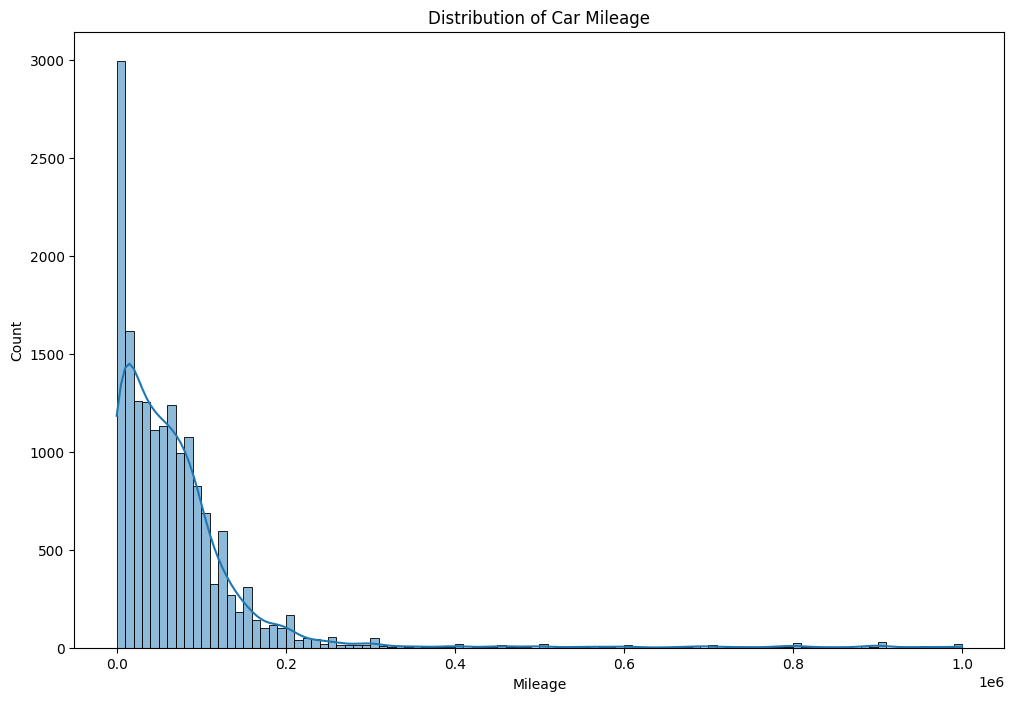

In [74]:
# Visualize the mileage distribution
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x='mileage_v2', bins=100, kde=True)
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.show()


This is heavily skewed, we need to investigate it as well

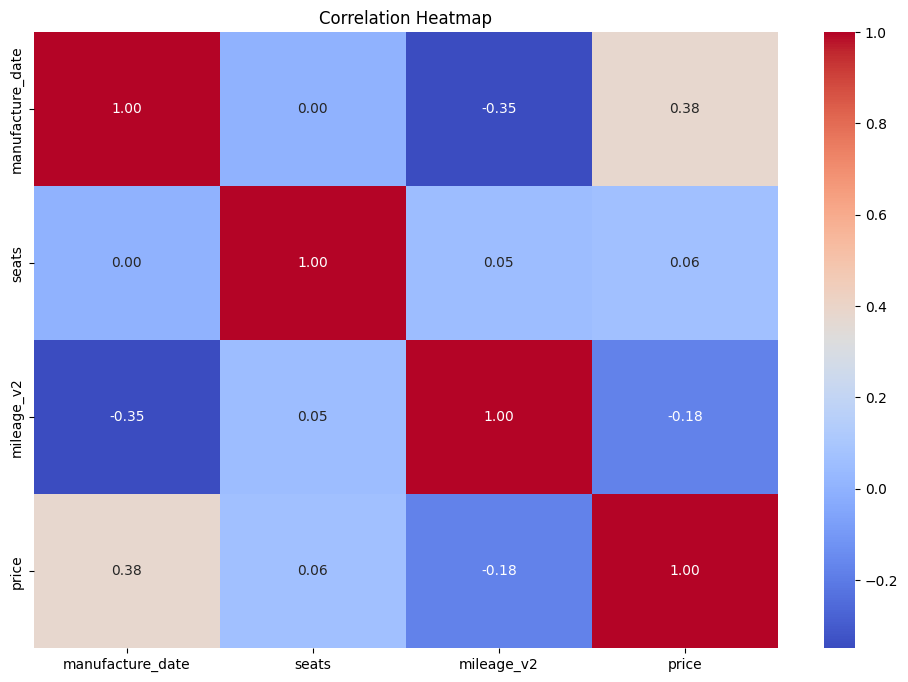

In [75]:
# Visualize the correlation between the numerical columns with the target variable
# Select numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data=data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Price is correlate with manufacture_data positively because of price, this may be because of new cars are more expensive. Additionally, mileage also have a negative correlation with price, maybe because when we travel more, the car become less valuable. Remember that this is solely based on number since correlation does not impose causalation

### Back to handling outlier

In [76]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [77]:
# Create a dictionary to store unique models for each brand
outlier_data = data.copy()
brand_models_dict = {}

# Loop through each brand in brand_counts_below_cutoff
for brand in brand_counts_below_cutoff['brand']:
    unique_models = outlier_data[outlier_data['brand'] == brand]['model'].unique()
    brand_models_dict[brand] = unique_models.tolist()

brand_models_dict


{'Toyota': ['Vios',
  'Innova',
  'Camry',
  'Avanza',
  'Fortuner',
  'Veloz',
  'Zace',
  'Veloz Cross',
  'Corolla Cross',
  'Yaris',
  'Raize',
  'Wigo',
  'Corolla Altis',
  'Hilux',
  'Cressida',
  'Land Cruiser',
  'Corolla',
  'Rush',
  'Hiace',
  'Venza',
  'Liteace',
  'Sienna',
  'Corona',
  'Land Cruiser Prado',
  'RAV4',
  'Tercel',
  'Dòng khác',
  'Century',
  'Prado',
  'Previa',
  'Alphard',
  'Prius',
  'Solara',
  'Highlander',
  '4 Runner',
  'Crown',
  'Aygo',
  'Celica',
  'Innova Cross',
  'Avalon',
  'Yaris Verso',
  'Tundra',
  'Sequoia',
  'Cami'],
 'Ford': ['Escape',
  'Ranger',
  'Focus',
  'Everest',
  'Dòng khác',
  'Transit',
  'Laser',
  'Fiesta',
  'EcoSport',
  'Explorer',
  'Tourneo',
  'Mondeo',
  'Territory',
  'F 150',
  'Mustang',
  'F 350',
  'Escort',
  'Wind star',
  'Express',
  'Focus C Max',
  'Caravan',
  'Acononline',
  'Ka',
  'Aspire'],
 'Kia': ['Morning',
  'Soluto',
  'Cerato',
  'Forte',
  'Rondo',
  'Carnival',
  'K3',
  'Rio',
  'Se

In [ ]:
# # Create a new column for color based on condition
# outlier_data['color'] = outlier_data['condition'].apply(lambda x: 'red' if x == 'new' else 'blue')

# # Loop through each brand and create a scatter plot
# for brand, models in brand_models_dict.items():
#     brand_data = outlier_data[outlier_data['brand'] == brand]
#     brand_data['model'] = brand_data['model'].astype('object')
    
#     plt.figure(figsize=(20, 10))
#     sns.scatterplot(data=brand_data, x='model', y='price', hue='condition', palette=['blue', 'red'], s=100)
    
#     # Customize the plot
#     plt.title(f'{brand} - Model and Price Scatter Plot')
#     plt.xlabel('Model')
#     plt.ylabel('Price')
#     plt.legend(title='Condition')
#     plt.xticks(rotation=90)  # Rotate x-axis labels vertically
#     plt.grid(False)  # Remove the grid
    
#     # Show the plot
#     plt.show()

We can see that each brand has model that is significantly higher than other, eventhough they are in the same model. This maybe outlier, however, I am not an expert, my approach is to leave these outlier alone. Which may be affect to the model's prediction power.

I don't know how to deal with this yet. However, let it be for now and focus on how each columns is related to the target columns.

In [ ]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


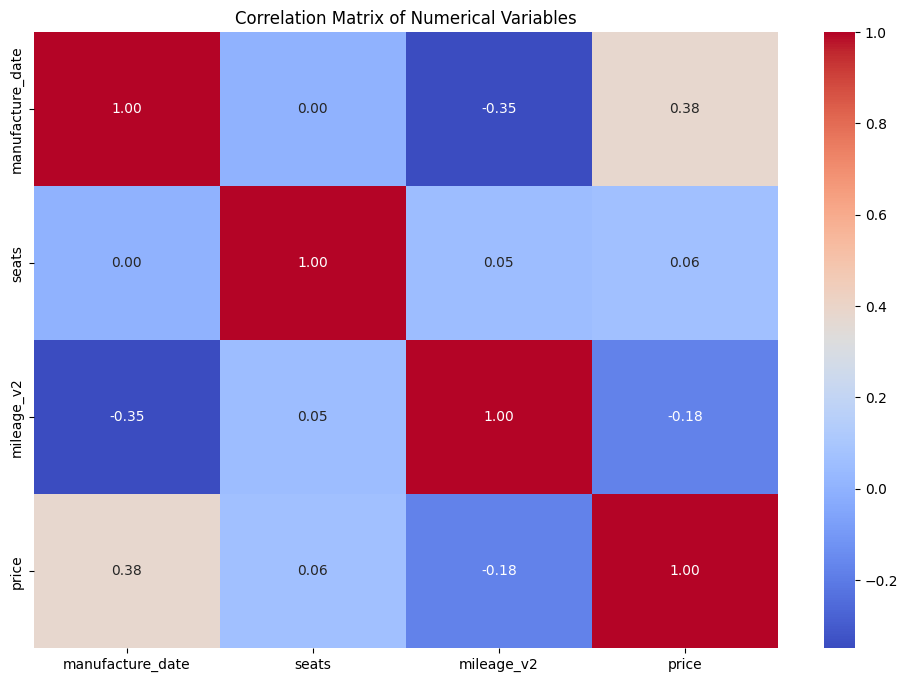

In [82]:

correlation_matrix = data.select_dtypes(np.number).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

In [80]:
# The following code is for encoding the categorical columns using LabelEncoder
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_columns = ['brand', 'model', 'origin', 'type', 'gearbox', 'fuel', 'color', 'condition']

# Initialize the LabelEncoder
label_encoders = {}

# Copy the original dataframe
encoded_data = data.copy()

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

encoded_data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,3,61,2,7,5.0,1,3,11,23000,455000000.0,1
3,2020,10,238,6,7,5.0,2,3,11,99999,368000000.0,1
5,2022,4,83,6,7,5.0,1,3,11,45000,455000000.0,1
6,2018,10,128,6,6,8.0,2,3,11,60000,485000000.0,1
7,2020,8,247,3,3,7.0,2,3,11,50000,465000000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,5,133,0,7,5.0,1,3,0,64936,460000000.0,1
317585,2002,6,4,6,7,5.0,2,3,0,300000,85000000.0,1
317588,2019,4,13,6,7,5.0,2,3,10,12000,350000000.0,1
317607,2017,5,196,6,3,7.0,1,2,11,140000,730000000.0,1


In [125]:
import joblib

# Save the label encoder
joblib.dump(le, f'{MODEL_PATH}/label_encoder.joblib')

['models/label_encoder.joblib']

# Modeling and Evaluation

In [82]:
from api.preprocess import drop_unncessary_columns, cast_to_category, encode_cat_cols, convert_data_dmatrix
from api.constants import CAT_COLS, NUM_COLS, COLS_TO_CAST, COLS_TO_CAST, SAMPLE_DATA

I will try with catboost, lgbm, xgboost and other regression models as well.

## Train and split test

In [83]:
# Define the features and target variable
X = encoded_data.drop(columns=['price'])
y = encoded_data['price']

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (16302, 11), (16302,)
Validation set: (429, 11), (429,)
Test set: (430, 11), (430,)


In [84]:
# # Save the train, validation, and test sets to the specified directory
# X_train.to_csv(f"{DATA_PATH}/processed/X_train.csv", index=False)
# X_val.to_csv(f"{DATA_PATH}/processed/X_val.csv", index=False)
# X_test.to_csv(f"{DATA_PATH}/processed/X_test.csv", index=False)
# y_train.to_csv(f"{DATA_PATH}/processed/y_train.csv", index=False)
# y_val.to_csv(f"{DATA_PATH}/processed/y_val.csv", index=False)
# y_test.to_csv(f"{DATA_PATH}/processed/y_test.csv", index=False)

# # # Save the train, validation, and test sets to the specified directory with '_encoded' suffix
# # X_train.to_csv(f"{DATA_PATH}/processed/X_train_encoded.csv", index=False)
# # X_val.to_csv(f"{DATA_PATH}/processed/X_val_encoded.csv", index=False)
# # X_test.to_csv(f"{DATA_PATH}/processed/X_test_encoded.csv", index=False)
# # y_train.to_csv(f"{DATA_PATH}/processed/y_train_encoded.csv", index=False)
# # y_val.to_csv(f"{DATA_PATH}/processed/y_val_encoded.csv", index=False)
# # y_test.to_csv(f"{DATA_PATH}/processed/y_test_encoded.csv", index=False)

In [90]:
data

,manufacture_date,brand,model,origin,type,seats,gearbox,fuel,color,mileage_v2,price,condition
1,2021,Honda,City,Nhật Bản,Sedan,5.0,AT,petrol,white,23000,455000000.0,used
3,2020,Toyota,Vios,Việt Nam,Sedan,5.0,MT,petrol,white,99999,368000000.0,used
5,2022,Hyundai,Elantra,Việt Nam,Sedan,5.0,AT,petrol,white,45000,455000000.0,used
6,2018,Toyota,Innova,Việt Nam,SUV / Cross over,8.0,MT,petrol,white,60000,485000000.0,used
7,2020,Mitsubishi,Xpander,Nước khác,Minivan (MPV),7.0,MT,petrol,white,50000,465000000.0,used
...,...,...,...,...,...,...,...,...,...,...,...,...
317552,2016,Kia,K3,Hàn Quốc,Sedan,5.0,AT,petrol,black,64936,460000000.0,used
317585,2002,Mazda,323,Việt Nam,Sedan,5.0,MT,petrol,black,300000,85000000.0,used
317588,2019,Hyundai,Accent,Việt Nam,Sedan,5.0,MT,petrol,silver,12000,350000000.0,used
317607,2017,Kia,Sedona,Việt Nam,Minivan (MPV),7.0,AT,oil,white,140000,730000000.0,used


In [91]:
# Define the features and target variable
X = data.drop(columns=['price'])
y = data['price']

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

# Save the train, validation, and test sets to the specified directory
X_train.to_csv(f"{DATA_PATH}/processed/X_train.csv", index=False)
X_val.to_csv(f"{DATA_PATH}/processed/X_val.csv", index=False)
X_test.to_csv(f"{DATA_PATH}/processed/X_test.csv", index=False)
y_train.to_csv(f"{DATA_PATH}/processed/y_train.csv", index=False)
y_val.to_csv(f"{DATA_PATH}/processed/y_val.csv", index=False)
y_test.to_csv(f"{DATA_PATH}/processed/y_test.csv", index=False)

Training set: (16302, 11), (16302,)
Validation set: (429, 11), (429,)
Test set: (430, 11), (430,)


In [92]:
X_train_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_train_encoded.csv")
X_val_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_val_encoded.csv")
X_test_encoded = pd.read_csv(f"{DATA_PATH}/processed/X_test_encoded.csv")
y_train_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_train_encoded.csv")
y_val_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_val_encoded.csv")
y_test_encoded = pd.read_csv(f"{DATA_PATH}/processed/y_test_encoded.csv")
# # For original data
X_train = pd.read_csv(f"{DATA_PATH}/processed/X_train.csv")
X_val = pd.read_csv(f"{DATA_PATH}/processed/X_val.csv")
X_test = pd.read_csv(f"{DATA_PATH}/processed/X_test.csv")
y_train = pd.read_csv(f"{DATA_PATH}/processed/y_train.csv")
y_val = pd.read_csv(f"{DATA_PATH}/processed/y_val.csv")
y_test = pd.read_csv(f"{DATA_PATH}/processed/y_test.csv")


In [93]:
# # Define the features and target variable
# X = data.drop(columns=['price'])
# y = data['price']

# # Split the data into training and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# # Split the temporary set into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (16302, 11), (16302, 1)
Validation set: (429, 11), (429, 1)
Test set: (430, 11), (430, 1)


We load the encoded version for catboost and lgbm. The original version for XGBoost

## Try with the baseline first
What we are going to do to establish a baseline is to build a simple model

In [94]:
# Convert object columns in X_train, X_val, and X_test to category
X_train = cast_to_category(X_train, CAT_COLS)
X_val = cast_to_category(X_val, CAT_COLS)
X_test = cast_to_category(X_test, CAT_COLS)

In [95]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, missing=np.NAN)
dval= xgb.DMatrix(X_val, label=y_val, enable_categorical=True, missing=np.NAN)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True, missing=np.NAN)

Since XGBoost need to specify to allow NaN, we have to create NaN for it as well.

In [96]:
xgb_params = {
    'objective': 'reg:squarederror',  
    'max_depth': 13,
    'eta': 0.5,
    'enable_categorical': True,
    "n_estimators": 1000,
    "reg_lambda": 1,
    "random_state": 42
}

/home/ngnqaq/anaconda3/envs/xai-venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:45:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 1.088161675580655e+18
R^2 Score: -3.559565848571271
Mean Absolute Error: 579312530.326923


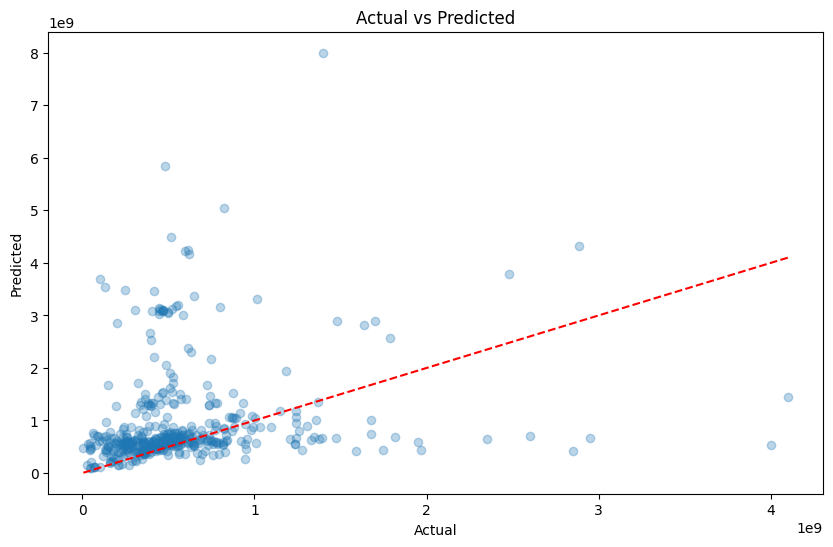

In [97]:
xgb_model=xgb.train(xgb_params, dtrain, num_boost_round=500, evals=[(dval, 'eval')], verbose_eval=0)
# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [336]:
xgb_model.save_model(f'{MODEL_PATH}/xgb_model.json')

The result is quite ok, the R^2 is quite high tho. Let move on to catboost

In [98]:
from catboost import CatBoostRegressor, Pool
categorical_features = X_train_encoded.select_dtypes(include='category').columns.tolist()

# Create Pool for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_val, y_val, cat_features=categorical_features)


In [121]:
# Define the model params
cat_params = {
    'loss_function': 'MAE',
    'iterations': 40000,
    'learning_rate': 0.2,
    'cat_features': categorical_features,
    'verbose': 100,
}

0:	learn: 243871803.3443554	total: 18.7ms	remaining: 12m 27s
100:	learn: 80660628.4177770	total: 431ms	remaining: 2m 50s
200:	learn: 70965750.8868626	total: 876ms	remaining: 2m 53s
300:	learn: 66031028.5837405	total: 1.5s	remaining: 3m 17s
400:	learn: 62428581.1817326	total: 1.96s	remaining: 3m 13s
500:	learn: 59837727.1524747	total: 2.48s	remaining: 3m 15s
600:	learn: 58263615.8187761	total: 2.78s	remaining: 3m 2s
700:	learn: 56710081.6638185	total: 3.09s	remaining: 2m 53s
800:	learn: 55671435.8420793	total: 3.47s	remaining: 2m 49s
900:	learn: 54437944.0530211	total: 3.85s	remaining: 2m 47s
1000:	learn: 53654560.5232623	total: 4.27s	remaining: 2m 46s
1100:	learn: 52973127.5328596	total: 4.67s	remaining: 2m 44s
1200:	learn: 52414272.6320571	total: 5.03s	remaining: 2m 42s
1300:	learn: 51776168.4492832	total: 5.35s	remaining: 2m 39s
1400:	learn: 51369056.0023465	total: 5.64s	remaining: 2m 35s
1500:	learn: 51033675.0050302	total: 5.91s	remaining: 2m 31s
1600:	learn: 50614175.5858491	total

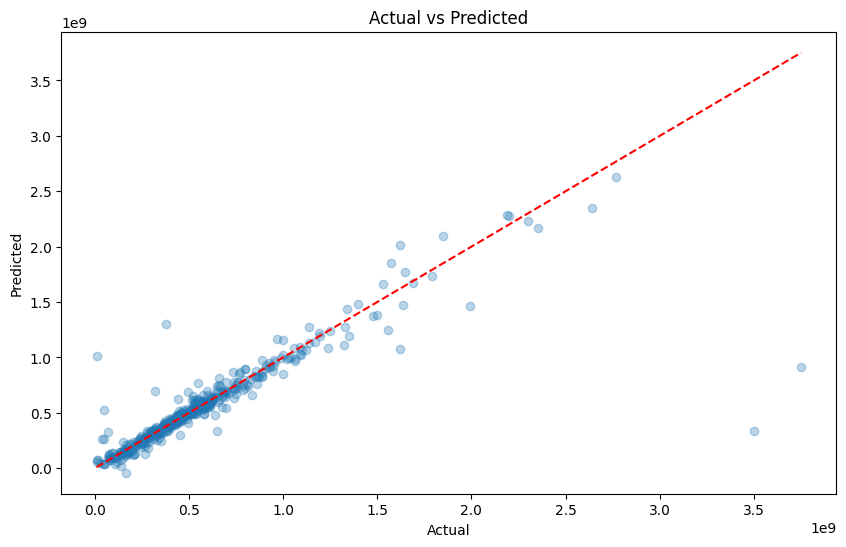

In [122]:
# Train the model
model = CatBoostRegressor(**cat_params)
model.fit(train_pool)

# Predict on the test set
y_pred = model.predict(test_pool)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [124]:
model.save_model(f'{MODEL_PATH}/catboost_model.cbm')

In [123]:
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 5.333183401013267e+16
Mean Absolute Error: 65398339.4304736
R^2 Score: 0.7415486825686214


Hmmmmm, the best till now

In [114]:
import lightgbm as lgb

# Define parameters
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

In [115]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_encoded, label=y_train_encoded)
test_data = lgb.Dataset(X_test_encoded, label=y_test_encoded, reference=train_data)

In [116]:
X_train_encoded.shape, y_train.shape

((16302, 11), (16302, 1))

In [117]:
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=15000, valid_sets=[train_data, test_data])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 16302, number of used features: 11
[LightGBM] [Info] Start training from score 537842727.678322


In [118]:
y_pred = lgbm_model.predict(X_test_encoded, num_iteration=lgbm_model.best_iteration)

In [119]:
# Evaluate the model
mse = mean_squared_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)
mae = mean_absolute_error(y_test_encoded, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 3.698444150086218e+16
Mean Absolute Error: 96240589.2669115
R^2 Score: 0.8450294655839365


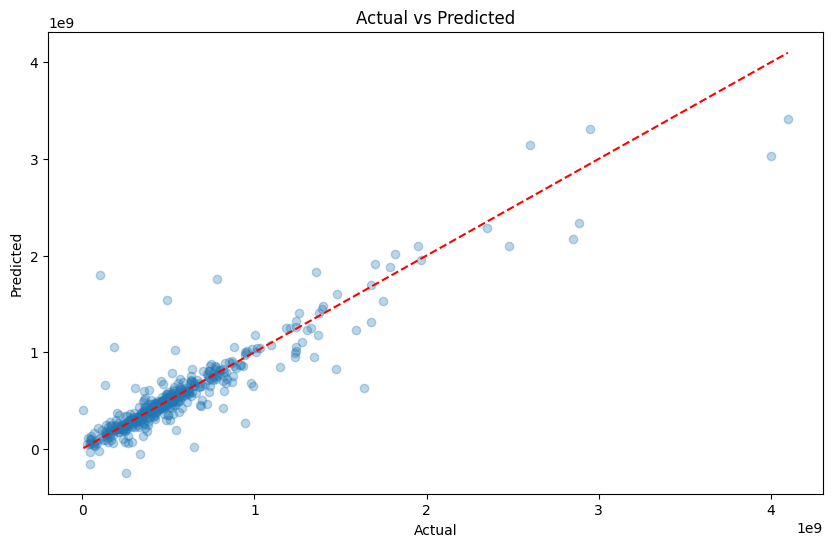

In [120]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()